In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [0]:
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

In [0]:
# Encoder and decoder use the DC-GAN architecture
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])])
        fc1 = fc_lrelu(conv2, 1024)
        return tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)

In [0]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output

In [5]:
# Build the computation graph for training
z_dim = 20
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_z = encoder(train_x, z_dim)
train_xr = decoder(train_z)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Build the computation graph for generating samples
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

In [0]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [0]:
# Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
true_samples = tf.random_normal(tf.stack([200, z_dim]))
loss_mmd = compute_mmd(true_samples, train_z)

In [9]:
loss_nll = tf.reduce_mean(tf.square(train_xr - train_x))
loss = loss_nll + loss_mmd
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [0]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
batch_size = 200
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Negative log likelihood is 0.231295, mmd loss is 0.003629


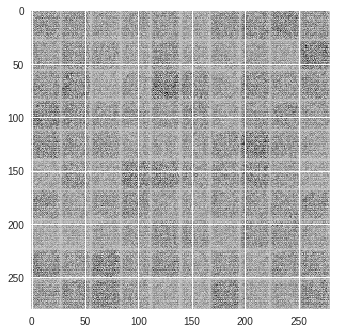

Negative log likelihood is 0.035989, mmd loss is 0.001920
Negative log likelihood is 0.019410, mmd loss is 0.001090
Negative log likelihood is 0.013985, mmd loss is 0.000798
Negative log likelihood is 0.010781, mmd loss is 0.001320
Negative log likelihood is 0.008945, mmd loss is 0.001322


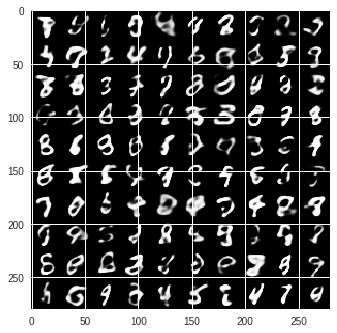

Negative log likelihood is 0.008543, mmd loss is 0.000769
Negative log likelihood is 0.008019, mmd loss is 0.000894
Negative log likelihood is 0.007552, mmd loss is 0.000634
Negative log likelihood is 0.007520, mmd loss is 0.001776
Negative log likelihood is 0.006693, mmd loss is 0.000661


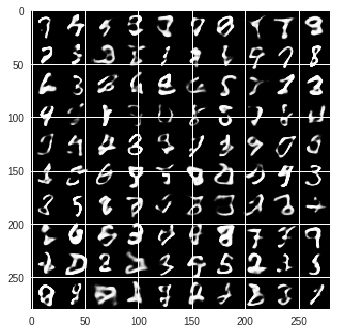

Negative log likelihood is 0.006636, mmd loss is 0.001532
Negative log likelihood is 0.006622, mmd loss is 0.000976
Negative log likelihood is 0.006561, mmd loss is 0.001338
Negative log likelihood is 0.005742, mmd loss is 0.001386
Negative log likelihood is 0.005539, mmd loss is 0.001495


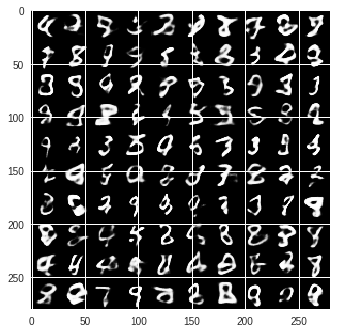

Negative log likelihood is 0.006216, mmd loss is 0.000728
Negative log likelihood is 0.005523, mmd loss is 0.001119
Negative log likelihood is 0.005375, mmd loss is 0.001508
Negative log likelihood is 0.005976, mmd loss is 0.002025
Negative log likelihood is 0.005208, mmd loss is 0.000945


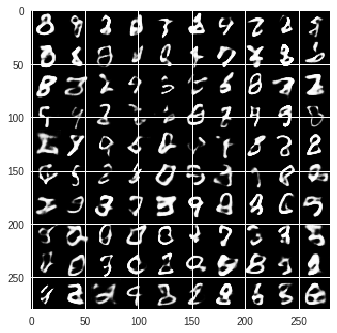

Negative log likelihood is 0.005551, mmd loss is 0.001324
Negative log likelihood is 0.005127, mmd loss is 0.001319
Negative log likelihood is 0.005458, mmd loss is 0.000947
Negative log likelihood is 0.005287, mmd loss is 0.001793
Negative log likelihood is 0.004777, mmd loss is 0.001984


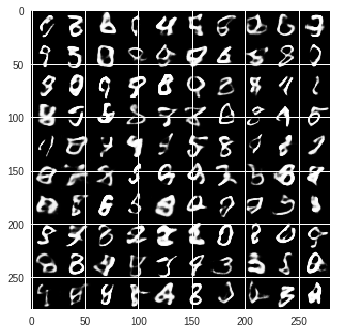

Negative log likelihood is 0.005253, mmd loss is 0.001133
Negative log likelihood is 0.005131, mmd loss is 0.000969
Negative log likelihood is 0.005088, mmd loss is 0.001644
Negative log likelihood is 0.005428, mmd loss is 0.001105
Negative log likelihood is 0.005183, mmd loss is 0.001117


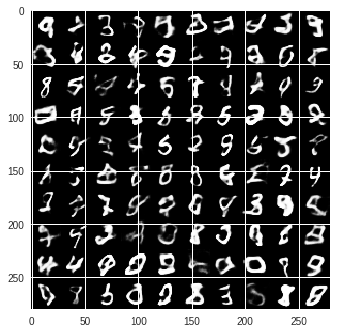

Negative log likelihood is 0.005329, mmd loss is 0.000729
Negative log likelihood is 0.004616, mmd loss is 0.001115
Negative log likelihood is 0.004924, mmd loss is 0.001285
Negative log likelihood is 0.004509, mmd loss is 0.001292
Negative log likelihood is 0.004963, mmd loss is 0.000694


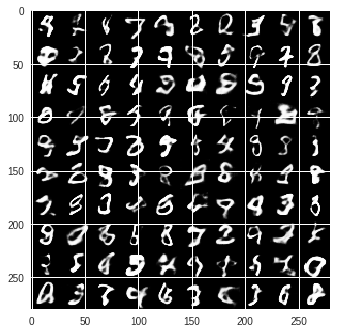

Negative log likelihood is 0.004511, mmd loss is 0.000588
Negative log likelihood is 0.004432, mmd loss is 0.001382
Negative log likelihood is 0.004534, mmd loss is 0.001161
Negative log likelihood is 0.004739, mmd loss is 0.000736
Negative log likelihood is 0.004641, mmd loss is 0.000815


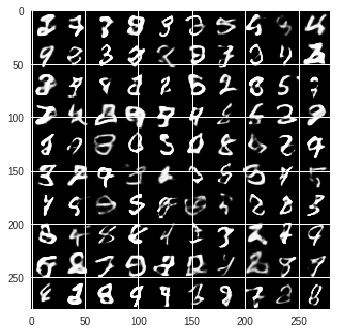

Negative log likelihood is 0.004662, mmd loss is 0.000621
Negative log likelihood is 0.004339, mmd loss is 0.001915
Negative log likelihood is 0.004454, mmd loss is 0.001301
Negative log likelihood is 0.004244, mmd loss is 0.000850
Negative log likelihood is 0.004370, mmd loss is 0.001212


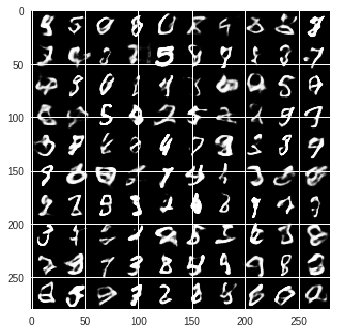

Negative log likelihood is 0.004238, mmd loss is 0.001204
Negative log likelihood is 0.004230, mmd loss is 0.001686
Negative log likelihood is 0.004364, mmd loss is 0.001374
Negative log likelihood is 0.004469, mmd loss is 0.000802
Negative log likelihood is 0.004492, mmd loss is 0.001282


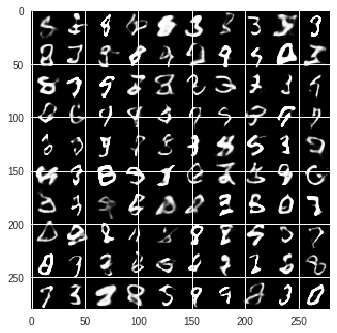

Negative log likelihood is 0.004015, mmd loss is 0.001116
Negative log likelihood is 0.004042, mmd loss is 0.001498
Negative log likelihood is 0.004043, mmd loss is 0.001756
Negative log likelihood is 0.004357, mmd loss is 0.001000
Negative log likelihood is 0.003619, mmd loss is 0.001446


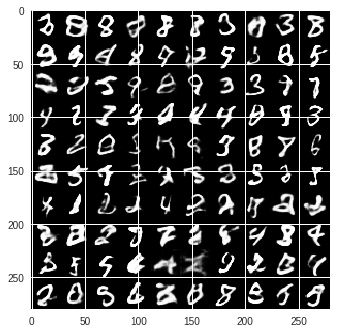

Negative log likelihood is 0.004004, mmd loss is 0.001162
Negative log likelihood is 0.004142, mmd loss is 0.000587
Negative log likelihood is 0.004048, mmd loss is 0.001809
Negative log likelihood is 0.004199, mmd loss is 0.001169
Negative log likelihood is 0.003832, mmd loss is 0.000924


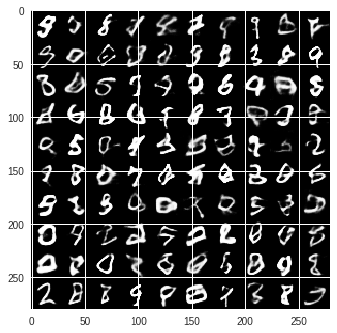

Negative log likelihood is 0.004127, mmd loss is 0.001416
Negative log likelihood is 0.003643, mmd loss is 0.000928
Negative log likelihood is 0.004068, mmd loss is 0.000720
Negative log likelihood is 0.003982, mmd loss is 0.000734
Negative log likelihood is 0.004047, mmd loss is 0.001244


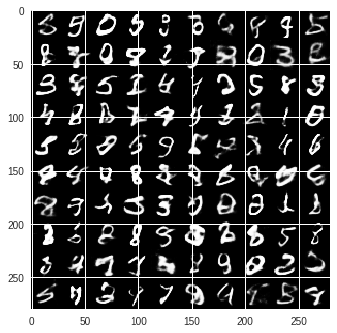

Negative log likelihood is 0.003791, mmd loss is 0.001530
Negative log likelihood is 0.004096, mmd loss is 0.000976
Negative log likelihood is 0.003832, mmd loss is 0.000888
Negative log likelihood is 0.003573, mmd loss is 0.001611
Negative log likelihood is 0.003656, mmd loss is 0.001568


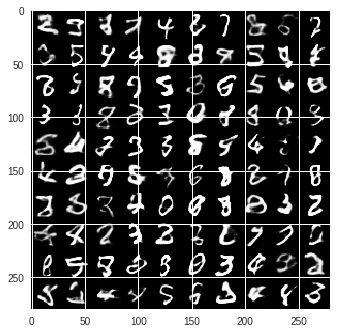

Negative log likelihood is 0.003572, mmd loss is 0.001721
Negative log likelihood is 0.003660, mmd loss is 0.000944
Negative log likelihood is 0.003767, mmd loss is 0.001449
Negative log likelihood is 0.003729, mmd loss is 0.001060
Negative log likelihood is 0.003631, mmd loss is 0.000939


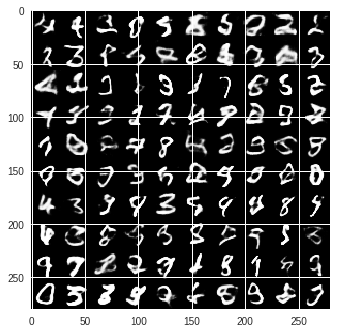

Negative log likelihood is 0.003574, mmd loss is 0.001410
Negative log likelihood is 0.003512, mmd loss is 0.000628
Negative log likelihood is 0.003687, mmd loss is 0.001763
Negative log likelihood is 0.003603, mmd loss is 0.001670
Negative log likelihood is 0.003783, mmd loss is 0.000570


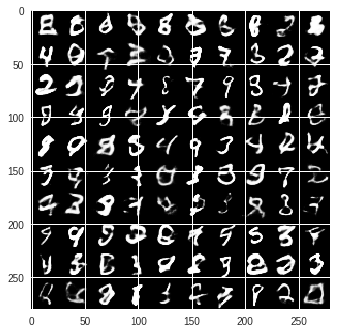

Negative log likelihood is 0.003754, mmd loss is 0.000984
Negative log likelihood is 0.003532, mmd loss is 0.000865
Negative log likelihood is 0.003418, mmd loss is 0.001336
Negative log likelihood is 0.003509, mmd loss is 0.000891
Negative log likelihood is 0.003797, mmd loss is 0.000997


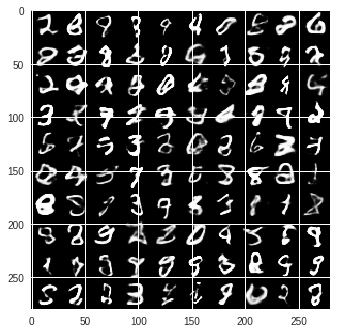

Negative log likelihood is 0.003711, mmd loss is 0.000877
Negative log likelihood is 0.003869, mmd loss is 0.000488
Negative log likelihood is 0.003591, mmd loss is 0.001343
Negative log likelihood is 0.003605, mmd loss is 0.001682
Negative log likelihood is 0.003457, mmd loss is 0.001309


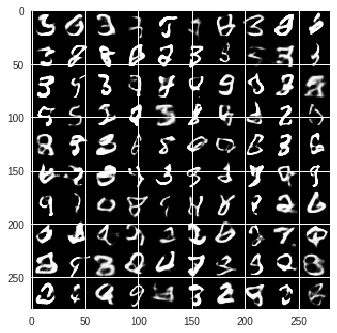

Negative log likelihood is 0.003236, mmd loss is 0.000979
Negative log likelihood is 0.003376, mmd loss is 0.000932
Negative log likelihood is 0.003589, mmd loss is 0.000819
Negative log likelihood is 0.003191, mmd loss is 0.001235
Negative log likelihood is 0.003386, mmd loss is 0.000832


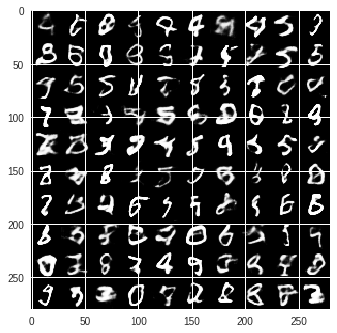

Negative log likelihood is 0.003694, mmd loss is 0.001139
Negative log likelihood is 0.003317, mmd loss is 0.000996
Negative log likelihood is 0.003407, mmd loss is 0.001287
Negative log likelihood is 0.003391, mmd loss is 0.001036


In [13]:
# Start training
for i in range(10000):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, mmd = sess.run([trainer, loss_nll, loss_mmd], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, mmd loss is %f" % (nll, mmd))
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

In [0]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    z_list, label_list = [], []
    test_batch_size = 500
    for i in range(20):
        batch_x, batch_y = mnist.test.next_batch(test_batch_size)
        batch_x = batch_x.reshape(-1, 28, 28, 1)
        z_list.append(sess.run(train_z, feed_dict={train_x: batch_x}))
        label_list.append(batch_y)
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()